In [80]:
import torch
import prologue
from tqdm import tqdm
#from functions import *
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [81]:
import torch
import torch.nn.functional as F
import numpy as np

def add_noise_to_image(image, noise_level_min=0.5, noise_level_max=0.8, p_noise_mean=0, p_noise_std=1):
    """
    Adds Gaussian noise to an input image.

    Parameters:
    - image: Input image tensor of shape [3, 32, 32]
    - noise_level_min: Minimum noise level σ
    - noise_level_max: Maximum noise level σ
    - p_noise_mean: Mean of the Gaussian noise
    - p_noise_std: Standard deviation of the Gaussian noise

    Returns:
    - Noisy image
    """
    # Sample a random noise level σ
    sigma = np.random.uniform(noise_level_min, noise_level_max)

    # Generate Gaussian noise
    epsilon = np.random.normal(p_noise_mean, p_noise_std, image.shape)

    # Create the noisy image
    noisy_image = image + sigma * epsilon
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure pixel values are within [0, 1]

    return noisy_image, sigma


def preprocess_with_convolution(image, num_filters=16, kernel_size=3, stride=2, padding=1):
    """
    Applies a convolutional layer to an image to reduce its dimensionality.

    Args:
    - image (torch.Tensor): Input image tensor of shape (batch_size, channels, height, width).
    - num_filters (int): Number of output channels (filters) for the convolution.
    - kernel_size (int): Size of the convolutional kernel.
    - stride (int): Stride for the convolution to control downsampling.
    - padding (int): Padding for the convolution to maintain spatial dimensions before downsampling.

    Returns:
    - torch.Tensor: Flattened tensor suitable for input to an MLP.
    """
    # Initialize convolutional filter weights and bias manually
    conv_weights = torch.randn(num_filters, image.size(1), kernel_size, kernel_size) * 0.1
    conv_bias = torch.randn(num_filters) * 0.1

    #print(conv_weights.dtype)
    

    # Ensure the weights and bias tensors have the same data type as the input image tensor
    #conv_weights = conv_weights.to(image.dtype)
    #conv_bias = conv_bias.to(image.dtype)

    # Apply convolution operation
    feature_map = F.conv2d(image, conv_weights, bias=conv_bias, stride=stride, padding=padding)
    
    # Flatten the output for MLP input
    flattened_output = feature_map.view(feature_map.size(0), -1)
    return flattened_output

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        """# Initialize weights and biases to match manual implementation
        with torch.no_grad():
            self.fc1.weight = nn.Parameter(w1.clone())
            self.fc1.bias = nn.Parameter(b1.squeeze().clone())
            self.fc2.weight = nn.Parameter(w2.clone())
            self.fc2.bias = nn.Parameter(b2.squeeze().clone())"""

    def forward(self, x):
        # Forward pass equivalent to your manual implementation
        x = self.fc1(x)
        x = torch.sigmoid(x)  # Activation after the first layer
        x = self.fc2(x)
        x = torch.sigmoid(x)  # Activation after the second layer
        return x
    
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DeepMLP, self).__init__()
        # Define the layers
        self.layers = nn.ModuleList()
        current_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(current_size, hidden_size))
            current_size = hidden_size
        
        # Add output layer
        self.output_layer = nn.Linear(current_size, output_size)

    def forward(self, x):
        # Forward pass through hidden layers with ReLU activation
        for layer in self.layers:
            x = F.relu(layer(x))
        
        # Forward pass through output layer
        x = self.output_layer(x)
        return x
   
class DeepMLP(nn.Module):
    def __init__(self, input_channels, hidden_sizes, output_size, num_filters1=16, num_filters2=32, kernel_size=3, stride=1, padding=1):
        super(DeepMLP, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(input_channels, num_filters1, kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size, stride, padding)
        
        # Calculate the size of the flattened output from the convolutional layers
        dummy_input = torch.zeros(1, input_channels, 32, 32)  # Assuming input images are 32x32
        conv_output_size = self._get_conv_output_size(dummy_input)
        
        # Define the fully connected layers
        self.fc_layers = nn.ModuleList()
        current_size = conv_output_size
        for hidden_size in hidden_sizes:
            self.fc_layers.append(nn.Linear(current_size, hidden_size))
            current_size = hidden_size
        self.output_layer = nn.Linear(current_size, output_size)

    def _get_conv_output_size(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x.view(1, -1).size(1)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor while keeping the batch size
        
        # Apply fully connected layers with ReLU activation
        for fc in self.fc_layers:
            x = F.relu(fc(x))
        
        # Apply output layer
        x = self.output_layer(x)
        return x

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CIFAR-10 dataset with images in their original shape
train_input, _, test_input, _ = prologue.load_data(cifar=True, normalize=True, flatten=False)



# Initialize lists to store noisy images
noisy_train_input = []
noisy_test_input = []

# Initialize lists to store flattened images
flattened_train_input = []
flattened_test_input = []

# Initialize lists to store flattened images
flattened_noisy_train_input = []
flattened_noisy_test_input = []

# Add noise to all train_input images
for image in train_input:
    noisy_image, _ = add_noise_to_image(image)
    noisy_train_input.append(torch.tensor(noisy_image, dtype = torch.float32))
    flattened_image = image.view(-1)  # Flatten the image to a 1D tensor
    flattened_train_input.append(flattened_image)
    
    flattened_noisy_image = noisy_image.view(-1)  # Flatten the image to a 1D tensor
    flattened_noisy_train_input.append(flattened_noisy_image)

# Add noise to all test_input images
for image in test_input:
    noisy_image, _ = add_noise_to_image(image)
    noisy_test_input.append(torch.tensor(noisy_image, dtype = torch.float32))
    flattened_image = image.view(-1)  # Flatten the image to a 1D tensor
    flattened_test_input.append(flattened_image)
    flattened_noisy_image = noisy_image.view(-1)  # Flatten the image to a 1D tensor
    flattened_noisy_test_input.append(flattened_noisy_image)

# Convert lists to tensors
noisy_train_input = torch.stack(noisy_train_input).float()
noisy_test_input = torch.stack(noisy_test_input).float()

# Convert lists to tensors
flattened_train_input = torch.stack(flattened_train_input).float()
flattened_test_input = torch.stack(flattened_test_input).float()
"""
# Convert lists to tensors
flattened_noisy_train_input = torch.stack(flattened_noisy_train_input).float()
flattened_noisy_test_input = torch.stack(flattened_noisy_test_input).float()

# Use the original images as targets
train_target = train_input
test_target = test_input
"""
"""
# Apply convolutional preprocessing to reduce dimensionality
noisy_train_input_conv = []
noisy_test_input_conv = []

for image in noisy_train_input:
    # Add a batch dimension for compatibility with conv2d
    image = image.unsqueeze(0)  # Shape: (1, channels, height, width)
    processed_image = preprocess_with_convolution(image)
    noisy_train_input_conv.append(processed_image)

for image in noisy_test_input:
    image = image.unsqueeze(0)  # Shape: (1, channels, height, width)
    processed_image = preprocess_with_convolution(image)
    noisy_test_input_conv.append(processed_image)

# Stack processed images into tensors
noisy_train_input_conv = torch.cat(noisy_train_input_conv)
noisy_test_input_conv = torch.cat(noisy_test_input_conv)

# Check the shape to confirm it matches expectations
print("Shape of flattened train_input:", flattened_train_input.shape)
print("Shape of flattened test_input:", flattened_test_input.shape)

# Check the shape to confirm it matches MLP input expectations
print("Shape after convolution and flattening (train):", noisy_train_input_conv.shape)
print("Shape after convolution and flattening (test):", noisy_test_input_conv.shape)
"""
batch_siz = 1
# Use DataLoader for batching
train_dataset = TensorDataset(noisy_train_input, flattened_train_input)
train_loader = DataLoader(train_dataset, batch_size=batch_siz, shuffle=True)

test_dataset = TensorDataset(noisy_test_input, flattened_test_input)
test_loader = DataLoader(test_dataset, batch_size=batch_siz, shuffle=False)


* Using CIFAR
Files already downloaded and verified
Files already downloaded and verified
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


C:\Users\sohei\AppData\Local\Temp\ipykernel_19136\3065972638.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_train_input.append(torch.tensor(noisy_image, dtype = torch.float32))
C:\Users\sohei\AppData\Local\Temp\ipykernel_19136\3065972638.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_test_input.append(torch.tensor(noisy_image, dtype = torch.float32))


In [84]:
#input_shape = flattened_noisy_train_input.shape[1]
output_shape = flattened_train_input.shape[1]
nb_neurons_1 = 50

nb_tr_samples = noisy_train_input.shape[0]
#eta = 0.1 / nb_tr_samples
eta = 0.1
x = flattened_noisy_train_input
t = flattened_train_input


In [85]:

"""
# Initialize the model
model = MLP(input_shape, nb_neurons_1, output_shape)
"""
input_channels = 3  # CIFAR-10 images have 3 channels (RGB)
hidden_sizes = [256, 128, 64]  # Example: Decreasing number of neurons
model = DeepMLP2(input_channels, hidden_sizes, output_shape).to(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=eta)

# Training loop
nb_epochs = 100
for epoch in tqdm(range(nb_epochs), desc="Training"):
    model.train()
    total_loss = 0
    for x_batch, t_batch in train_loader:
        x_batch = x_batch.to(device)  # Move to GPU
        t_batch = t_batch.to(device)  # Move to GPU
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(x_batch)

        # Compute loss
        loss = criterion(output, t_batch)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

    """# Optionally print the loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss / len(train_loader)}')
    """

Training: 100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


In [86]:
# Testing loop
model.eval()
final_values_test_tensor = torch.empty_like(flattened_test_input)
with torch.no_grad():
    for n, (x_batch, _) in enumerate(test_loader):
        x_batch = x_batch.to(device)  # Move to GPU
        output = model(x_batch)
        final_values_test_tensor[n * batch_siz:(n + 1) * batch_siz] = output


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

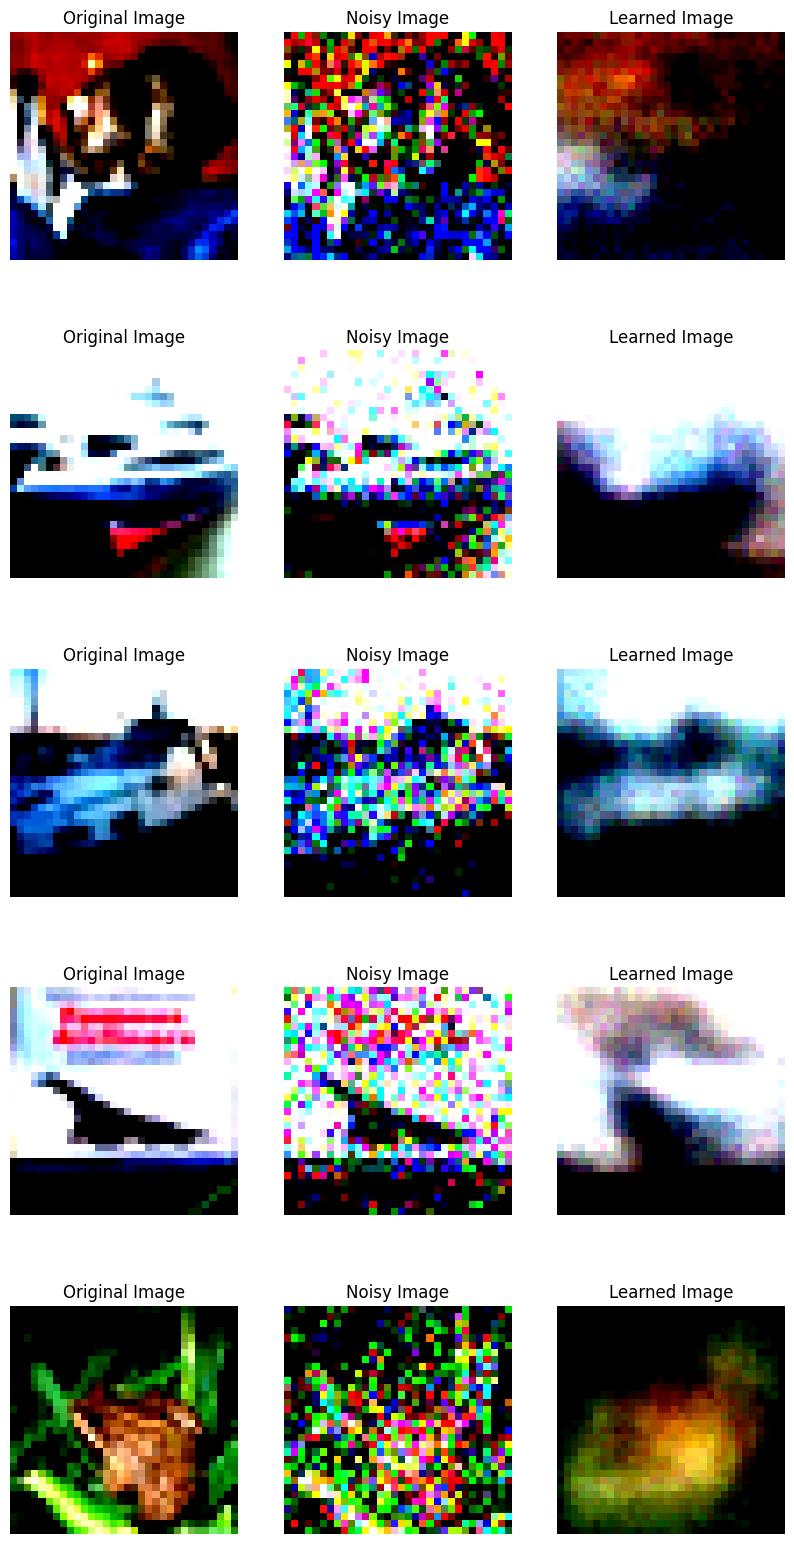

In [87]:
# Visualize the first 5 test images and their corresponding learned images
fig, axes = plt.subplots(5, 3, figsize=(10, 20))
for i in range(5):
    # Original image
    axes[i, 0].imshow(test_input[i].permute(1, 2, 0).numpy())
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    # Noisy image
    axes[i, 1].imshow(noisy_test_input[i].permute(1, 2, 0).numpy())
    axes[i, 1].set_title("Noisy Image")
    axes[i, 1].axis('off')

    # Learned image
    learned_image = final_values_test_tensor[i].view(3, 32, 32).permute(1, 2, 0).numpy()
    axes[i, 2].imshow(learned_image)
    axes[i, 2].set_title("Learned Image")
    axes[i, 2].axis('off')

plt.show()